# Projeto ICD - Classificação
## Classificando a decisão de jogada no turno com base nos demais atributos

Nesse modelo de classificação, tentaremos prever qual decisão de jogada o indivíduo tomará com base na situção atual do jogo.
Aplicaremos os modelos kNN e regressão logística com a variável prevista sendo a ação do jogador naquele turno, definida em "Action".
Verificaremos a acurácia e revocação de cada método para avaliar seus desempenhos para essa classificação.
Por fim, compararemos os métodos utilizando seus intervalos de confiança obtidos por meio do método de bootstrap.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV

### Carregando dados tratados:

In [2]:
df_class = pd.read_csv('poker_dados_clasf.csv')
df_class.head()

,Action,Position,Hand,Pot,P1-Action,P1-Bet,P2-Action,P2-Bet,P3-Action,P3-Bet,P4-Action,P4-Bet,P5-Action,P5-Bet
0,f,2,3169,150.0,sb,50.0,bb,100.0,hold,0.0,hold,0.0,hold,0.0
1,f,3,3257,150.0,sb,50.0,bb,100.0,f,0.0,hold,0.0,hold,0.0
2,r,4,133,150.0,sb,50.0,bb,100.0,f,0.0,f,0.0,hold,0.0
3,f,5,2465,375.0,sb,50.0,bb,100.0,f,0.0,f,0.0,r,225.0
4,f,0,7217,375.0,bb,100.0,f,0.0,f,0.0,r,225.0,f,0.0


In [3]:
colunas_numericas = ['Position',
                     'Hand',
                     'Pot',
                     'P1-Bet',
                     'P2-Bet',
                     'P3-Bet',
                     'P4-Bet',
                     'P5-Bet'
                    ]

colunas_classes = ['P1-Action',
                   'P2-Action',
                   'P3-Action',
                   'P4-Action',
                   'P5-Action'
                   ]

### Separando em Teste/Treino:

In [4]:
class_X = df_class.copy()
class_X.drop('Action', axis=1, inplace=True)
class_y = df_class['Action']
class_X.head(2)

,Position,Hand,Pot,P1-Action,P1-Bet,P2-Action,P2-Bet,P3-Action,P3-Bet,P4-Action,P4-Bet,P5-Action,P5-Bet
0,2,3169,150.0,sb,50.0,bb,100.0,hold,0.0,hold,0.0,hold,0.0
1,3,3257,150.0,sb,50.0,bb,100.0,f,0.0,hold,0.0,hold,0.0


In [5]:
class_X_train, class_X_test, class_y_train, class_y_test = train_test_split(class_X, class_y, test_size=0.2)
print(class_X_train.shape)
print(class_X_test.shape)

(34080, 13)
(8521, 13)


### Normalizando os dados:

In [6]:
class_mean_train = class_X_train[colunas_numericas].mean()
class_std_train = class_X_train[colunas_numericas].std(ddof=1)

class_Z_train = class_X_train.copy()
class_Z_train[colunas_numericas] = class_X_train[colunas_numericas] - class_mean_train
class_Z_train[colunas_numericas] = class_Z_train[colunas_numericas] / class_std_train

class_Z_test = class_X_test.copy()
class_Z_test[colunas_numericas] = class_X_test[colunas_numericas] - class_mean_train
class_Z_test[colunas_numericas] = class_Z_test[colunas_numericas] / class_std_train

In [7]:
class_D_train = pd.get_dummies(class_Z_train)
class_D_test = pd.get_dummies(class_Z_test)
class_D_train.head(2)

,Position,Hand,Pot,P1-Bet,P2-Bet,P3-Bet,P4-Bet,P5-Bet,P1-Action_bb,P1-Action_c,...,P3-Action_hold,P3-Action_r,P4-Action_c,P4-Action_f,P4-Action_hold,P4-Action_r,P5-Action_c,P5-Action_f,P5-Action_hold,P5-Action_r
24873,1.446761,-1.009942,0.334148,-0.154471,0.33485,-0.417396,-0.373442,2.000682,0,0,...,0,0,0,1,0,0,0,0,0,1
33013,0.861510,-1.500324,-0.602386,-0.154471,0.33485,-0.417396,-0.373442,-0.328947,0,0,...,0,0,0,1,0,0,0,0,1,0


## Modelo de classificação - kNN

### Validação Cruzada KNN:

In [8]:
# Fazendo a validação cruzada.

fold = 1
skf = StratifiedKFold(n_splits= 8)
melhores = []
for train_index, val_index in skf.split(class_D_train, class_y_train):
    print('Fold -> ', fold)
    best = (0,0)
    for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        model = KNeighborsClassifier(n_neighbors= k)
        model.fit(class_D_train.values[train_index], class_y_train.values[train_index])
        
        y_val = class_y_train.values[val_index]
        y_hat = model.predict(class_D_train.values[val_index])
        
        accuracy = accuracy_score(y_val, y_hat)
        if accuracy > best[0]:
            best = (accuracy, k)
    print('Melhor -> ', best[1], ' com valor ', best[0])
    melhores.append(best[1])
    print()
    print()
    fold += 1

Fold ->  1
Melhor ->  10  com valor  0.9155326137963398


Fold ->  2
Melhor ->  10  com valor  0.9127170342562178


Fold ->  3
Melhor ->  8  com valor  0.9187984041304857


Fold ->  4
Melhor ->  7  com valor  0.9204038506691712


Fold ->  5
Melhor ->  7  com valor  0.915707912655553


Fold ->  6
Melhor ->  9  com valor  0.9152383188541912


Fold ->  7
Melhor ->  5  com valor  0.9121859591453393


Fold ->  8
Melhor ->  9  com valor  0.9131251467480629




8.125
8.5


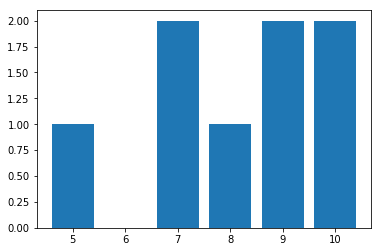

In [9]:
# Verificando melhor 'k'.

unique, counts = np.unique(melhores, return_counts= True)
plt.bar(unique, counts)
print(np.mean(melhores))
print(np.median(melhores))

### Treino e Teste KNN:

In [10]:
# Calculando precisão, revocação e F1 para o kNN com 'k = 7'.

model_kNN = KNeighborsClassifier(n_neighbors= 7)
model_kNN.fit(class_D_train.values, class_y_train.values)

print(classification_report(class_y_test, model_kNN.predict(class_D_test)))

              precision    recall  f1-score   support

           c       0.66      0.68      0.67       777
           f       0.96      0.96      0.96      6229
           r       0.86      0.82      0.84      1515

   micro avg       0.91      0.91      0.91      8521
   macro avg       0.83      0.82      0.82      8521
weighted avg       0.91      0.91      0.91      8521



### Matriz de confusão dos dados:

Text(0.5,0,'Verdadeiro')

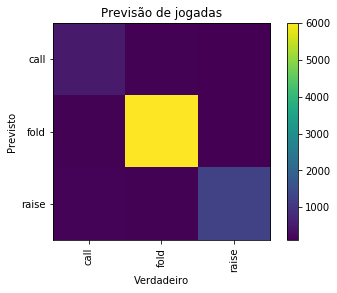

In [11]:
# Exibindo a matriz de confusão do kNN.

plt.imshow(confusion_matrix(class_y_test, model_kNN.predict(class_D_test)))
plt.xticks([0, 1, 2], ['call', 'fold',  'raise'], rotation=90)
plt.yticks([0, 1, 2], ['call', 'fold',  'raise'])
plt.colorbar()
plt.title('Previsão de jogadas')
plt.ylabel('Previsto')
plt.xlabel('Verdadeiro')

## Modelo de classificação - Regressão Logística

### Treino e Teste da regressão:

In [12]:
# Fazendo a regressão logística regularizada.<br>

## - Regressão Linear## Modelo de classificação - kNN### Treino e Teste KNN:

model_RL = LogisticRegressionCV(Cs = 100,
                             penalty = 'l2',
                             cv = 5,
                             fit_intercept = False,
                             multi_class = 'ovr')
model_RL.fit(class_D_test, class_y_test)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_mode

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=False, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [13]:
# Calculando precisão, revocação e F1 para a Regressão Logística.

print(classification_report(class_y_test, model_RL.predict(class_D_test)))

              precision    recall  f1-score   support

           c       0.73      0.53      0.61       777
           f       0.93      0.97      0.95      6229
           r       0.80      0.79      0.79      1515

   micro avg       0.89      0.89      0.89      8521
   macro avg       0.82      0.76      0.78      8521
weighted avg       0.89      0.89      0.89      8521



### Matriz de confusão dos dados:

Text(0.5,0,'Verdadeiro')

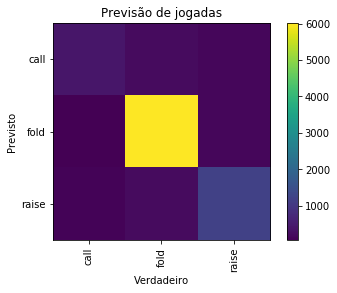

In [14]:
# Exibindo a matriz de confusão da regressão.

plt.imshow(confusion_matrix(class_y_test, model_RL.predict(class_D_test)))
plt.xticks([0, 1, 2], ['call', 'fold',  'raise'], rotation=90)
plt.yticks([0, 1, 2], ['call', 'fold',  'raise'])
plt.colorbar()
plt.title('Previsão de jogadas')
plt.ylabel('Previsto')
plt.xlabel('Verdadeiro')

## Comparando os modelos:

In [15]:
# Comparando precisões (acurácias por se tratarem de mais de duas classes).

print('Precisão do kNN: ', accuracy_score(class_y_test, model_kNN.predict(class_D_test)))
print('Precisão da Regressão Logística: ', accuracy_score(class_y_test, model_RL.predict(class_D_test)))

Precisão do kNN:  0.9125689473066542
Precisão da Regressão Logística:  0.8949653796502758


### Definindo bootstrap:

In [16]:
# Criando a função bootstrap para calcular o IC de cada modelo.

def bootstrap_accuracy(X, y, model, n= 10):
    size = len(X)
    values = np.zeros(n)
    idx = np.arange(len(X))
    for i in range(n):
        sample = np.random.choice(idx, size= size, replace= True)
        values[i] = accuracy_score(y.values[sample], model.predict(X.values[sample]))
    return values

In [17]:
sample_kNN = bootstrap_accuracy(class_D_test, class_y_test, model_kNN)

In [18]:
sample_RL = bootstrap_accuracy(class_D_test, class_y_test, model_RL)

In [19]:
# Calculando o IC da precisão de cada modelo.

knn_ic_inf = np.percentile(sample_kNN, 2.5)
knn_ic_sup = np.percentile(sample_kNN, 97.5)
rl_ic_inf = np.percentile(sample_RL, 2.5)
rl_ic_sup = np.percentile(sample_RL, 97.5)

print('IC do kNN: (', knn_ic_inf, ',', knn_ic_sup,')')
print('IC do Regressão Logística: (', rl_ic_inf, ',', rl_ic_sup,')')

IC do kNN: ( 0.908065367914564 , 0.91526229315808 )
IC do Regressão Logística: ( 0.8923189766459336 , 0.9019510620819152 )


O desempenho da classificação foi muito bom, sendo consideravelmente competente em prever a jogada que será feita naquele turno com base nos atributos que sintetizam a situação atual do jogo, apresentando acurácias notavelmente altas para as previsões de cada grupo. Essa afirmação é válida para os dois métodos, apesar de que, pela análise dos intervalos de confiança do bootstrap das acurácias de cada método, o kNN é estatísticamente melhor, mesmo que só um pouco.